In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def quat_angle_error(q1, q2):
    q1 = q1 / np.linalg.norm(q1)
    q2 = q2 / np.linalg.norm(q2)
    dot = np.clip(np.abs(np.dot(q1, q2)), -1.0, 1.0)
    return 2 * np.arccos(dot)

In [ ]:
data = []
with h5py.File("../dataset.h5", "r") as f:
    primitives = f.attrs["primitives"]

    for scene_id in f.keys():
        dp = f[scene_id]
        num_objects = len(dp["poses"])
        for oi in range(num_objects):
            object_pose = dp["poses"][oi]
            object_size = dp["sizes"][oi]
            target_pose = dp["target_poses"][oi]
            for pi, primitive in enumerate(primitives):
                primitive_parts = primitive.split("_")
                data.append(
                    {
                        "scene_id": scene_id,
                        "object_id": oi,
                        "object_pose": object_pose,
                        "object_size": object_size,
                        "target_pose": target_pose,
                        "primitive": primitive,
                        "primitive_type": primitive_parts[0],
                        "primitive_axis": primitive_parts[1],
                        "feasible": bool(dp["feasibles"][oi][pi]),
                        "final_pose": dp["final_poses"][oi][pi],
                    }
                )

df = pd.DataFrame(data)
print(f"Loaded {len(df)} attempts from {df['scene_id'].nunique()} scenes.")

df["object_volume"] = df["object_size"].apply(np.prod)
df["target_pose_key"] = df["target_pose"].apply(lambda x: tuple(np.round(x, 6)))

print(df.iloc[0])

Loaded 397552 attempts from 10996 scenes.


KeyError: 'distance'

In [ ]:
feas_by_type = df.groupby("primitive_type")["feasible"].mean().reset_index()
print(feas_by_type)

plt.figure(figsize=(12, 6))
sns.barplot(data=feas_by_type, x="primitive_type", y="feasible")
plt.title("Mean Feasibility Rate by Primitive")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
feas_by_prim = df.groupby("primitive")["feasible"].mean().reset_index()
print(feas_by_prim)

plt.figure(figsize=(12, 6))
sns.barplot(data=feas_by_prim, x="primitive", y="feasible")
plt.title("Mean Feasibility Rate by Primitive")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Collapse primitives into primitive_type-level feasibility
df_typelevel = df.groupby(
    ["scene_id", "object_id", "target_pose_key", "primitive_type"],
    as_index=False,
).agg(
    {
        "feasible": "any",
        "object_pose": "first",
        "object_size": "first",
        "final_pose": "first",
        "distance": "first",
        "object_volume": "first",
    }
)
print(f"Reduced from {len(df)} primitive-level attempts to {len(df_typelevel)} type-level attempts.")

feas_by_type_collapsed = df_typelevel.groupby("primitive_type")["feasible"].mean().reset_index()
print(feas_by_type_collapsed)

sns.barplot(data=feas_by_type_collapsed, x="primitive_type", y="feasible")
plt.title("Mean Feasibility Rate by Primitive Type (Collapsed)")
plt.ylim(0, 1)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x="primitive_type", y="pos_diff", data=df_feas)
plt.title("Position Error by Primitive Type")

plt.subplot(1, 2, 2)
sns.boxplot(x="primitive_type", y="quat_diff", data=df_feas)
plt.title("Quat Error by Primitive Type")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x="distance", y="pos_diff", hue="primitive_type", data=df_feas, alpha=0.7)
plt.title("Position Error vs Initial Distance")
plt.xlabel("Initial Distance to Target")
plt.ylabel("Position Error")

plt.subplot(1, 2, 2)
sns.scatterplot(x="object_volume", y="pos_diff", hue="primitive_type", data=df_feas, alpha=0.7)
plt.title("Position Error vs Object Volume")
plt.xlabel("Object Volume")
plt.ylabel("Position Error")
plt.tight_layout()
plt.show()

In [ ]:
summary_data = []

for (scene_id, object_id), group in df.groupby(["scene_id", "object_id"]):
    push_feasible = group[group["primitive_type"] == "push"]["feasible"].any()
    pull_feasible = group[group["primitive_type"] == "pull"]["feasible"].any()
    lift_feasible = group[group["primitive_type"] == "lift"]["feasible"].any()

    # Build category label
    feasible_types = []
    if push_feasible:
        feasible_types.append("push")
    if pull_feasible:
        feasible_types.append("pull")
    if lift_feasible:
        feasible_types.append("lift")

    if feasible_types:
        category = "_".join(sorted(feasible_types))
    else:
        category = "none"

    summary_data.append(
        {
            "scene_id": scene_id,
            "object_id": object_id,
            "push": push_feasible,
            "pull": pull_feasible,
            "lift": lift_feasible,
            "category": category,
        }
    )

df_summary = pd.DataFrame(summary_data)
print(df_summary.iloc[0])

In [ ]:
cat_counts = df_summary["category"].value_counts(normalize=True)
print(cat_counts)
plt.figure(figsize=(10, 5))
sns.barplot(x=cat_counts.index, y=cat_counts.values)
plt.title("Task-achievability by motion type combinations")
plt.show()

In [ ]:
from robotic.manipulation import Manipulation
from robotic.scenario import PandaScenario


def visualise(df: pd.DataFrame, scene_id: str, object_id: int, only=["push", "lift", "pull"]):
    df_case = df[(df["scene_id"] == scene_id) & (df["object_id"] == object_id)]
    print(df_case[["primitive", "feasible"]])

    seed = int(scene_id.replace("dp_", ""))
    config = PandaScenario()
    config.add_boxes(seed=seed)
    obj = config.man_frames[object_id]
    target_pose = df_case["target_pose"].iloc[object_id]
    config.add_marker(target_pose)

    for primitive in Manipulation.primitives:
        if not primitive.startswith(tuple(only)):
            continue
        man = Manipulation(config, obj, slices=20)
        getattr(man, primitive)()
        man.target_pose(target_pose)
        feasible = man.solve().feasible
        man.view(pause=True, txt=f"{primitive}={feasible}")
        if feasible:
            man.simulate(view=True)

In [ ]:
cases = df_summary[df_summary["category"] == "pull"]
example = cases.iloc[0]
scene_id, object_id = example["scene_id"], example["object_id"]
print(scene_id, object_id)
# visualise(df, scene_id, object_id)

In [ ]:
def iqr(df: pd.DataFrame, col: str, group_col: str, threshold=1.5):
    outliers = []
    for _, group in df.groupby(group_col):
        values = group[col]

        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        mask = (values < lower) | (values > upper)

        flagged = group[mask]
        outliers.append(flagged)

    return pd.concat(outliers) if outliers else pd.DataFrame()


outliers = iqr(df_feas, "pos_diff", "primitive", threshold=1.5)
outliers = outliers.drop_duplicates(subset=["scene_id", "object_id", "primitive"]).reset_index(drop=True)

print(f"Found {len(outliers)} position outlier executions out of {len(df_feas)} feasible ones.")
print(outliers[["scene_id", "object_id", "primitive", "pos_diff"]].sort_values(by="pos_diff", ascending=False).head())

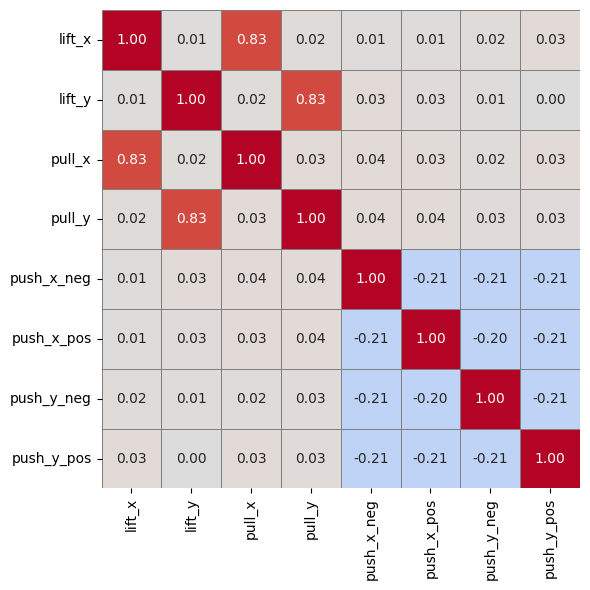

In [4]:
feas_matrix = df.pivot_table(index=["scene_id", "object_id"], columns="primitive", values="feasible", aggfunc="max")
feas_corr = feas_matrix.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(feas_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", cbar=False, square=True, linewidths=0.5, linecolor="gray")
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.tight_layout()
plt.savefig("primitive_correlation_heatmap.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
prims = df["primitive"].unique()
cond_probs = pd.DataFrame(index=prims, columns=prims, dtype=float)

for p1 in prims:
    for p2 in prims:
        mask = feas_matrix[p2] == 1
        cond_probs.loc[p1, p2] = feas_matrix.loc[mask, p1].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(cond_probs, annot=True, cmap="viridis", fmt=".2f")
plt.title("Conditional Feasibility: P(p1 feasible | p2 feasible)")
plt.tight_layout()
plt.show()

In [ ]:
pos_error_matrix = df_feas.pivot_table(index=["scene_id", "object_id"], columns="primitive", values="pos_diff")
quat_error_matrix = df_feas.pivot_table(index=["scene_id", "object_id"], columns="primitive", values="quat_diff")

pos_corr = pos_error_matrix.corr()
quat_corr = quat_error_matrix.corr()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(pos_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation of Position Errors Between Primitives")

plt.subplot(1, 2, 2)
sns.heatmap(quat_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation of Quaternion Errors Between Primitives")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
for i, axis in enumerate(["x", "y", "z"]):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df, x="primitive_type", y=df["object_size"].apply(lambda s: s[i]), hue="feasible")
    plt.title(f"{axis.upper()} Size vs Feasibility")
    plt.xlabel("Primitive Type")
    plt.ylabel(f"{axis.upper()} dimension [m]")
plt.tight_layout()
plt.show()

In [ ]:
bins = np.linspace(df["object_volume"].min(), df["object_volume"].max(), 20)
df["volume_bin"] = pd.cut(df["object_volume"], bins=bins)

# Get bin centers
bin_centers = {interval: interval.mid for interval in df["volume_bin"].cat.categories}
df["volume_bin_center"] = df["volume_bin"].map(bin_centers)

feas_volume = df.groupby(["primitive_type", "volume_bin_center"])["feasible"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=feas_volume, x="volume_bin_center", y="feasible", hue="primitive_type", marker="o")
plt.xlabel("Object Volume (bin center)")
plt.ylabel("Feasibility Rate")
plt.title("Feasibility vs Object Volume (by Primitive Type)")
plt.tight_layout()
plt.show()

In [ ]:
RELATIVE_THRESHOLD = 0.75  # allow up to 75% of distance

df_adj = df.copy()
df_adj["strict_feasible"] = df_adj["feasible"].copy()
mask_violation = (df_adj["feasible"]) & (df_adj["pos_diff"] > RELATIVE_THRESHOLD * df_adj["distance"])
df_adj.loc[mask_violation, "strict_feasible"] = False

converted_count = mask_violation.sum()
print(f"Converted {converted_count} datapoints from feasible -> infeasible ({converted_count / len(df):.2%} of dataset).")

converted_by_prim = df_adj.loc[mask_violation, "primitive"].value_counts().reset_index().rename(columns={"index": "primitive", "primitive": "count"})
print("Primitives most affected by strict feasibility:")
print(converted_by_prim)

plt.figure(figsize=(14, 5))
for i, axis in enumerate(["x", "y", "z"]):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df_adj, x="primitive_type", y=df["object_size"].apply(lambda s: s[i]), hue="feasible")
    plt.title(f"{axis.upper()} Size vs Feasibility")
    plt.xlabel("Primitive Type")
    plt.ylabel(f"{axis.upper()} dimension [m]")
plt.tight_layout()
plt.show()